# Background

This notebook showcases how to leverage Optuna for hyperparameter tuning, specifically for the n_lists and n_probes parameters. We will demonstrate how to optimize these parameters using Optuna's Bayesian optimization capabilities.

Note: This notebook has been tested on Sagemaker Studio with an instance type of ml.g5.12xlarge.

In [ ]:
#Install Required Packages
%micromamba install -c conda-forge -c nvidia -c rapidsai cuvs optuna -y
%pip install cupy

In [2]:
import cupy as cp
import numpy as np
from cuvs.neighbors import ivf_flat
import urllib.request
import numpy as np
import time
import optuna
from utils import calc_recall
from optuna.visualization import plot_optimization_history
import math


## Download wiki-all dataset

In [3]:
import tarfile
home_dir = os.path.expanduser("~/")
#wiki-all datasets are in tar format
def download_files(url, file):
    if os.path.exists(home_dir + "/" + file):
        print("tar file is already downloaded")
    else:
        urllib.request.urlretrieve(url, home_dir + "/" + file)
    # Open the .tar file
    with tarfile.open(home_dir + "/" + file, 'r') as tar:
        filename = file.split(".")[0]
        if os.path.exists(home_dir + "/" + filename + "/"):
            print("Files already extracted")
            return home_dir + "/" + filename + "/"
        # Extract all contents into the specified directory
        extract_path=home_dir + "/" +file.split(".")[0]
        tar.extractall(extract_path)
    return extract_path

In [ ]:
extracted_path=download_files('https://data.rapids.ai/raft/datasets/wiki_all_1M/wiki_all_1M.tar', 'wiki_all_1M.tar')

## Dataset Preparation: Load fbin, ibin files
This example utilizes the Wiki-1M dataset, a collection of four binary files containing:

1. **Database vectors**: Used for index building and searching.
2. **Query vectors**: Used for index building and searching.
3. **Ground truth neighbors**: Associated with a particular distance, used for evaluation.
4. **Distances**: Associated with a particular distance, used for evaluation.

The file suffixes denote the data type of vectors stored in the file:
* `.fbin`: float32
* `.ibin`: int

For more information on the Wiki-1M dataset, please refer to the [RAPIDS documentation](https://docs.rapids.ai/api/raft/nightly/ann_benchmarks_dataset/).

In [5]:
def read_data(file_path, dtype):
    with open(file_path, "rb") as f:
        rows,cols = np.fromfile(f, count=2, dtype= np.int32)
        d = np.fromfile(f,count=rows*cols,dtype=dtype).reshape(rows, cols)
    return cp.asarray(d)

In [6]:
vectors= read_data(extracted_path + "/base.1M.fbin",np.float32)
queries = read_data(extracted_path + "/queries.fbin",np.float32)
gt_neighbors = read_data(extracted_path + "/groundtruth.1M.neighbors.ibin",np.int32)

In [7]:
#Get the dataset size of database vectors
dataset_size = vectors.shape[0]


## Create an Objective function for Optuna

* The function uses the trial object to suggest values for two hyperparameters:
	+ `n_lists`: an integer between 0.5 and 1.5 times the square root of the dataset size.
	+ `n_probes`: an integer between 0.01 and 0.1 times the number of lists.

**Index Building and Search**

* The function builds the IVF Flat index using the suggested hyperparameters.
* It then performs a search on the index using a set of queries.

**Evaluation Metric**

* The recall is calculated based on the search results and the ground truth neighbors.

In [40]:
def objective(trial):
    """
    Optimizes the parameters for an Inverted File Index (IVF) Flat index.

    Parameters:
    trial (object): A trial object used to suggest values for the hyperparameters.

    Returns:
    float: The recall of the search results, rounded to 4 decimal places.
    """
    # Suggest an integer for the number of lists
    n_lists = trial.suggest_int("n_lists", math.sqrt(dataset_size)*0.5, math.sqrt(dataset_size)*1.5)
    # Suggest an integer for the number of probes
    n_probes = trial.suggest_int("n_probes",n_lists*0.01 , n_lists*0.1)
    build_params = ivf_flat.IndexParams(
        n_lists=n_lists,
        metric="euclidean",
        kmeans_trainset_fraction=0.1,
        kmeans_n_iters=20,
        add_data_on_build=True
    )
    index = ivf_flat.build(build_params, vectors)
    # Configure search parameters
    search_params = ivf_flat.SearchParams(n_probes=n_probes)
    # Perform the search
    distances, indices = ivf_flat.search(search_params, index, queries, k=10)
    found_distances, found_indices = cp.asnumpy(distances), cp.asnumpy(indices)
    recall = calc_recall(found_indices, gt_neighbors)
    return round(recall,4)

## Create an Optuna study

This study performs a Bayesian optimization to maximize the recall of an Inverted File Index (IVF) Flat index.

**Study Parameters**

* **Direction** (`str`): The direction of the optimization, set to `"maximize"` to maximize the recall.
* **Objective Function** (`function`): The function to be optimized, which suggests hyperparameters for the IVF Flat index and returns the recall.
* **Number of Trials** (`int`): The number of trials to run the optimization, this example sets this value 10.

**Optimization Goal**

The goal of this study is to maximize the recall of the search results, ensuring that the IVF Flat index returns the most relevant neighbors for a given query.

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2024-07-29 05:09:10,352] A new study created in memory with name: no-name-6637a666-6688-483c-ba23-fdea0b35da4f
[I 2024-07-29 05:09:21,470] Trial 0 finished with value: 0.9941 and parameters: {'n_lists': 863, 'n_probes': 68}. Best is trial 0 with value: 0.9941.
[I 2024-07-29 05:09:32,080] Trial 1 finished with value: 0.9939 and parameters: {'n_lists': 1397, 'n_probes': 90}. Best is trial 0 with value: 0.9941.
[I 2024-07-29 05:09:40,785] Trial 2 finished with value: 0.98 and parameters: {'n_lists': 1367, 'n_probes': 43}. Best is trial 0 with value: 0.9941.
[I 2024-07-29 05:09:49,483] Trial 3 finished with value: 0.9817 and parameters: {'n_lists': 1118, 'n_probes': 40}. Best is trial 0 with value: 0.9941.
[I 2024-07-29 05:10:00,699] Trial 4 finished with value: 0.9913 and parameters: {'n_lists': 567, 'n_probes': 46}. Best is trial 0 with value: 0.9941.
[I 2024-07-29 05:10:11,993] Trial 5 finished with value: 0.9953 and parameters: {'n_lists': 1164, 'n_probes': 92}. Best is trial 5 with

## Visualization

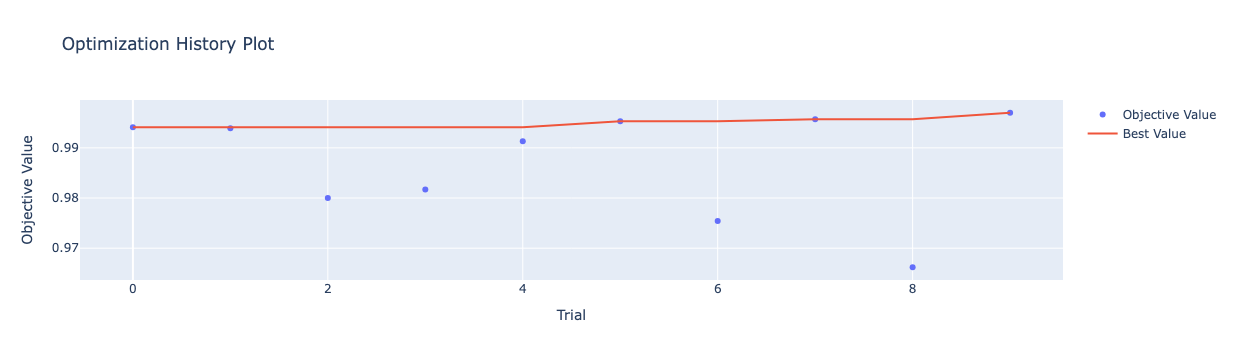

In [42]:
# Plot
optuna.visualization.plot_optimization_history(study)

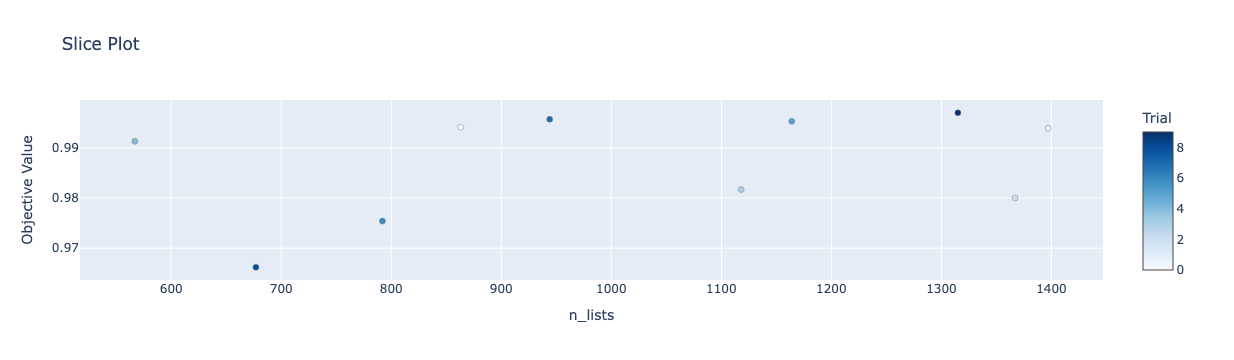

In [43]:
optuna.visualization.plot_slice(study, params=["n_lists"])
